# SPICY Tutorial 4
In this tutorial, we implement the constrained regression of a 3D velocity field. Depending on the available hardware, running this file can take considerable time of the order of up to 45 minutes or more.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io

import os
import sys
sys.path.append('..' + os.sep + 'spicy_vki' + os.sep + 'spicy')
from spicy_class import spicy


# This is for plot customization
fontsize = 12
plt.rc('text', usetex=True)      
plt.rc('font', family='serif')
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['font.size'] = fontsize

This test case is the 3D stokes flow past a sphere which is a typical benchmark test case. The flow has a free-stream velocity of $U_0$ around a sphere of radius $1$. The domain of interest is the thick shell which lies in $r \in [1, 2]$.  The theoretical solution of the flow field is available analytically and given by

$$
\begin{align}
u_r &= U_0 \left(1-\frac{3}{2}\frac{R}{r} + \frac{1}{2} \left(\frac{R}{r}\right)^3 \text{cos}(\theta) \right) \\
u_\theta &= U_0 \left(1 -\frac{3}{4}\frac{R}{r} - \frac{1}{4} \left(\frac{R}{r}\right)^3 \text{sin}(\theta) \right)
\end{align}
$$

The individual cartesian velocity components are obtained by means of these equations

$$
\begin{align}
 U &= u_r \,\text{cos}(\varphi)\,\text{sin}(\theta) + u_\theta\,\text{cos}(\varphi)\,\text{cos}(\theta) \\
 V &= u_r \,\text{sin}(\varphi)\,\text{sin}(\theta) + u_\theta\,\text{sin}(\varphi)\,\text{cos}(\theta) \\
 W &= u_r \,\text{cos}(\theta) - u_\theta\,\text{sin}(\theta)
\end{align}
$$

In this case, $W$ is the main flow direction parallel to the free-stream velocity. The corresponding theoretical pressure field is

$$
P = - \frac{3}{2} \frac{\mu U_0 R}{r^2} \text{cos}(\theta)
$$

For the preparation of the dataset, we create $40000$ random points in a cube of $(x,y,z) = [-2,2]\times[-2,2]\times[-2,2]$. We then only keep the points which are in the region $r \in [1,2]$. For each of these points, the velocity is then computed and 5% is noise is added as this test case is more challenging than the previous ones.

In [2]:
# Fix random seed to ensure reproducibility
np.random.seed(42)

# Physical size of the domain
D = 1; D2 = 2; R = D/2
LX = 2; LY = 2; LZ = 2
# The sphere is centered in (0,0,0)
X_center_sphere = 0
Y_center_sphere = 0
Z_center_sphere = 0
# Properties of the flow
U_0 = 1; mu = 1; rho = 0

# Number of points in the Cube [-2x2, -2x2, -2x2]. The actual number of points in the sphere is slightly less than 
# half of that
n_p = 40000

# These are the points in the cube
X_cube = np.random.random(n_p)*LX-LX/2
Y_cube = np.random.random(n_p)*LY-LY/2
Z_cube = np.random.random(n_p)*LZ-LZ/2

# And here we only take the ones which are contained within the shell between r = 1 and r = 2
Insidespherebool = (X_cube-X_center_sphere)**2+(Y_cube-Y_center_sphere)**2+(Z_cube-Z_center_sphere)**2-(D/2)**2>0
X = X_cube[Insidespherebool]
Y = Y_cube[Insidespherebool]
Z = Z_cube[Insidespherebool]
Outsidespherebool = (X-X_center_sphere)**2+(Y-Y_center_sphere)**2+(Z-Z_center_sphere)**2-(D2/2)**2<0
X = X[Outsidespherebool]
Y = Y[Outsidespherebool]
Z = Z[Outsidespherebool]
# Extract the actual number of points
n_p = X.size

# Calculating the velocities with the Stokes flow equations
phi = np.arctan2(Y-Y_center_sphere, X-X_center_sphere)
theta = np.arctan2(np.sqrt((X-X_center_sphere)**2 + (Y-Y_center_sphere)**2), (Z-Z_center_sphere))
r = np.sqrt((X-X_center_sphere)**2 + (Y-Y_center_sphere)**2 + (Z-Z_center_sphere)**2)
# Velocities in spherical coordinates
v_r = U_0*(1 - 3/2*R/r + 0.5*(R/r)**3)*np.cos(theta) 
v_th = -U_0*(1 - 3/4*R/r - 0.25*(R/r)**3)*np.sin(theta)
# Theoretical pressure field
P = -3/2*(mu*U_0*R/r**2)*np.cos(theta)
# Projected velocities
U = v_r*np.cos(phi)*np.sin(theta)+v_th*np.cos(phi)*np.cos(theta)
V = v_r*np.sin(phi)*np.sin(theta)+v_th*np.cos(theta)*np.sin(phi)
W = v_r*np.cos(theta)-v_th*np.sin(theta)

# Add 5% noise to the velocity field
q = 0.05
U_noise = U * (1 + q * np.random.uniform(-1, 1, size = U.shape))
V_noise = V * (1 + q * np.random.uniform(-1, 1, size = V.shape))
W_noise = W * (1 + q * np.random.uniform(-1, 1, size = W.shape))

### Step 1: Define the boundary conditions/constraints
We define the BC's below. We take 2163 points on the surface of the inner sphere, i.e. at $r = 1$ and 4961 points on the outer surface of the spherical region, i.e. at $r = 2$. On the inner points, we put Dirichlet and divergence-free conditions and on the outer points, only divergence-free condition. As the inner sphere is a wall, the velocity there is set to zero.

In [3]:
# Defining the constrint points (outer sphere)
N_phi_outer = 90 # We have N_phi_outer-2 different phi values on the outer sphere # 90
# These are the distinct phi values
phi_sphere_outer_ring = np.linspace(np.pi/N_phi_outer,np.pi*(N_phi_outer-1)/N_phi_outer,N_phi_outer-2)
# We compute the number of points which are on each of these different phi rings
NC_perth_outer = np.array(np.floor(N_phi_outer * np.sin(phi_sphere_outer_ring)), dtype=np.int)
# and remove the ones with 2 or less values
phi_sphere_outer_ring = phi_sphere_outer_ring[NC_perth_outer>=2]
NC_perth_outer = NC_perth_outer[NC_perth_outer>=2]
# We initialize the array collecting all of the theta and phi values with the values of the first ring
theta_sphere_outer = np.linspace(0,2*np.pi*(NC_perth_outer[0]-1)/NC_perth_outer[0],NC_perth_outer[0])
phi_sphere_outer = phi_sphere_outer_ring[0]*np.ones(len(theta_sphere_outer))
# Loop over the remaining rings
for k in np.arange(1,len(NC_perth_outer)):
    # Compute the Theta values on this Phi ring
    theta_sphere_outer_ring = np.linspace(0, 2*np.pi*(NC_perth_outer[k]-1)/NC_perth_outer[k], NC_perth_outer[k]-1)
    # Append them into the theta array
    theta_sphere_outer = np.hstack((theta_sphere_outer, theta_sphere_outer_ring))
    # Append the phi values. These are constant on each ring
    phi_sphere_outer = np.hstack((phi_sphere_outer, phi_sphere_outer_ring[k]*np.ones(len(theta_sphere_outer_ring))))
# Compute the 3D coordinates in X, Y, Z
X_Outer = 0.5*D2*np.cos(phi_sphere_outer)*np.sin(theta_sphere_outer) + X_center_sphere
Y_Outer = 0.5*D2*np.sin(phi_sphere_outer)*np.sin(theta_sphere_outer) + Y_center_sphere
Z_Outer = 0.5*D2*np.cos(theta_sphere_outer) + Z_center_sphere 

# Defining the constrint points (inner sphere)
N_phi_inner = 60 # We have N_phi_inner-2 different phi values on the inner sphere # 60
# These are the distinct phi values
phi_sphere_inner_ring = np.linspace(np.pi/N_phi_inner,np.pi*(N_phi_inner-1)/N_phi_inner,N_phi_inner-2)
# We compute the number of points which are on each of these different phi rings
NC_perth_inner=np.array(np.floor(N_phi_inner * np.sin(phi_sphere_inner_ring)),dtype=np.int)
# and remove the ones with 2 or less values
phi_sphere_inner_ring=phi_sphere_inner_ring[NC_perth_inner>=2]
NC_perth_inner=NC_perth_inner[NC_perth_inner>=2]
# We initialize the array collecting all of the theta and phi values with the values of the first ring
theta_sphere_inner=np.linspace(0,2*np.pi*(NC_perth_inner[0]-1)/NC_perth_inner[0],NC_perth_inner[0])
phi_sphere_inner=phi_sphere_inner_ring[0]*np.ones(len(theta_sphere_inner))
# Loop over the remaining rings
for k in np.arange(1, len(NC_perth_inner)):
    # Compute the Theta values on this Phi ring
    theta_sphere_inner_ring = np.linspace(0,2*np.pi*(NC_perth_inner[k]-1)/NC_perth_inner[k],NC_perth_inner[k]-1)
    # Append them into the theta array
    theta_sphere_inner = np.hstack((theta_sphere_inner,theta_sphere_inner_ring))
    # Append the phi values. These are constant on each ring
    phi_sphere_inner = np.hstack((phi_sphere_inner,phi_sphere_inner_ring[k]*np.ones(len(theta_sphere_inner_ring))))
# Compute the 3D coordinates in X, Y, Z
X_Inner = 0.5*D*np.cos(phi_sphere_inner)*np.sin(theta_sphere_inner) + X_center_sphere
Y_Inner = 0.5*D*np.sin(phi_sphere_inner)*np.sin(theta_sphere_inner) + Y_center_sphere
Z_Inner = 0.5*D*np.cos(theta_sphere_inner) + Z_center_sphere

# We assemble the velocity constraints for Dirichlet
X_Dir = X_Inner
Y_Dir = Y_Inner
Z_Dir = Z_Inner
# and Divergence-free flow
X_Div = np.concatenate((X_Outer, X_Inner))
Y_Div = np.concatenate((Y_Outer, Y_Inner))
Z_Div = np.concatenate((Z_Outer, Z_Inner))

# We remove the duplicates in the Dirichlet
_, valid_idcs = np.unique(np.column_stack((X_Div, Y_Div, Z_Div)), return_index = True, axis = 0)
X_Div = X_Div[valid_idcs]
Y_Div = Y_Div[valid_idcs]
Z_Div = Z_Div[valid_idcs]
DIV = [X_Div, Y_Div, Z_Div]

# and Divergence-free flow
_, valid_idcs = np.unique(np.column_stack((X_Dir, Y_Dir, Z_Dir)), return_index = True, axis = 0)
X_Dir = X_Dir[valid_idcs]
Y_Dir = Y_Dir[valid_idcs]
Z_Dir = Z_Dir[valid_idcs]
U_Dir = np.zeros(X_Dir.shape[0])
V_Dir = np.zeros(X_Dir.shape[0])
W_Dir = np.zeros(X_Dir.shape[0])
DIR = [X_Dir, Y_Dir, Z_Dir, U_Dir, V_Dir, W_Dir]

For this 3D case, the clustering in different areas is not yet implemented, given that a spherical domain would be required with refinements close to the wall. Instead, a global clustering approach is again used. We use three levels, with n_k=[6,60,1200].

Clustering level 0 completed
Clustering level 1 completed
Clustering level 2 completed
3402 RBFs placed through clustering
2106 D conditions assigned
0 N conditions assigned
6980 Div conditions assigned


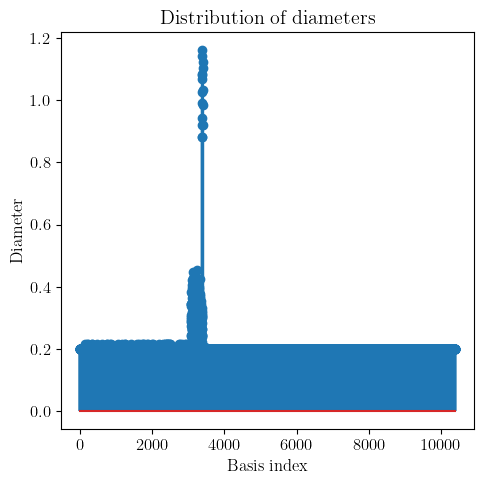

In [4]:
# Prepare the SPICY object
SP_vel = spicy([U_noise,V_noise,W_noise], [X,Y,Z], basis='gauss')
# Clustering
SP_vel.clustering([6,60,1200], Areas=[[], [], []], r_mM=[0.1, 0.65], eps_l=0.78)
# Introduce the constraints
SP_vel.vector_constraints(DIR=DIR, DIV=DIV, extra_RBF=True)
# Plot the RBF cluster. In 3D, they cannot be visualized properly anymore, so only the histogram is shown
SP_vel.plot_RBFs(l = 0)

### Step 2: RBF Training

We continue with the assembly of the linear system and the training of the RBF. Again, we use a fairly large K_cond and we also have a much larger penalty on a divergence-free flow. This is to ensure proper boundary conditions at the edges of the outer sphere at $r = 2$ for the pressure computation.

In [5]:
# Assembly the system
SP_vel.Assembly_Regression(alpha_div=25) 
# Solve the system
SP_vel.Solve(K_cond=1e12)


Solving with constraints
Matrix A regularized
Chol factor of M WITH regularization
Lambdas computed
w computed


Now we evaluate the error on the entire dataset.

In [6]:
U_calc, V_calc, W_calc = SP_vel.Get_Sol(grid = [X,Y,Z])

We can now compute the error in the magnitude.

In [7]:
# Magnitude of the RBF solution
U_magn_calc = np.sqrt(U_calc**2 + V_calc**2 + W_calc**2)
# Compute the magnitude of the analytical solution
U_magn = np.sqrt(U**2 + V**2 + W**2)
# Compute the error in the magnitude
error_magn = np.linalg.norm(U_magn_calc - U_magn) / np.linalg.norm(U_magn)
# Error in u
error_u = np.linalg.norm(U_calc - U) / np.linalg.norm(U)
# Error in v
error_v = np.linalg.norm(V_calc - V) / np.linalg.norm(V)
# Error in w
error_w = np.linalg.norm(W_calc - W) / np.linalg.norm(W)

print('Total velocity error: {0:.3f}%'.format(error_magn*100))
print('Velocity error in u:  {0:.3f}%'.format(error_u*100))
print('Velocity error in v:  {0:.3f}%'.format(error_v*100))
print('Velocity error in w:  {0:.3f}%'.format(error_w*100))

Total velocity error: 0.621%
Velocity error in u:  1.310%
Velocity error in v:  1.268%
Velocity error in w:  0.636%


The error in all three components is again below 1.5% which is very encouraging! For comparison, we plot the original data and RBF regression in a slice of the velocity field in the $x-y$ plane where we take the points within $-0.1 < z < 0.1$. Again, we challenge you to spot the differences!

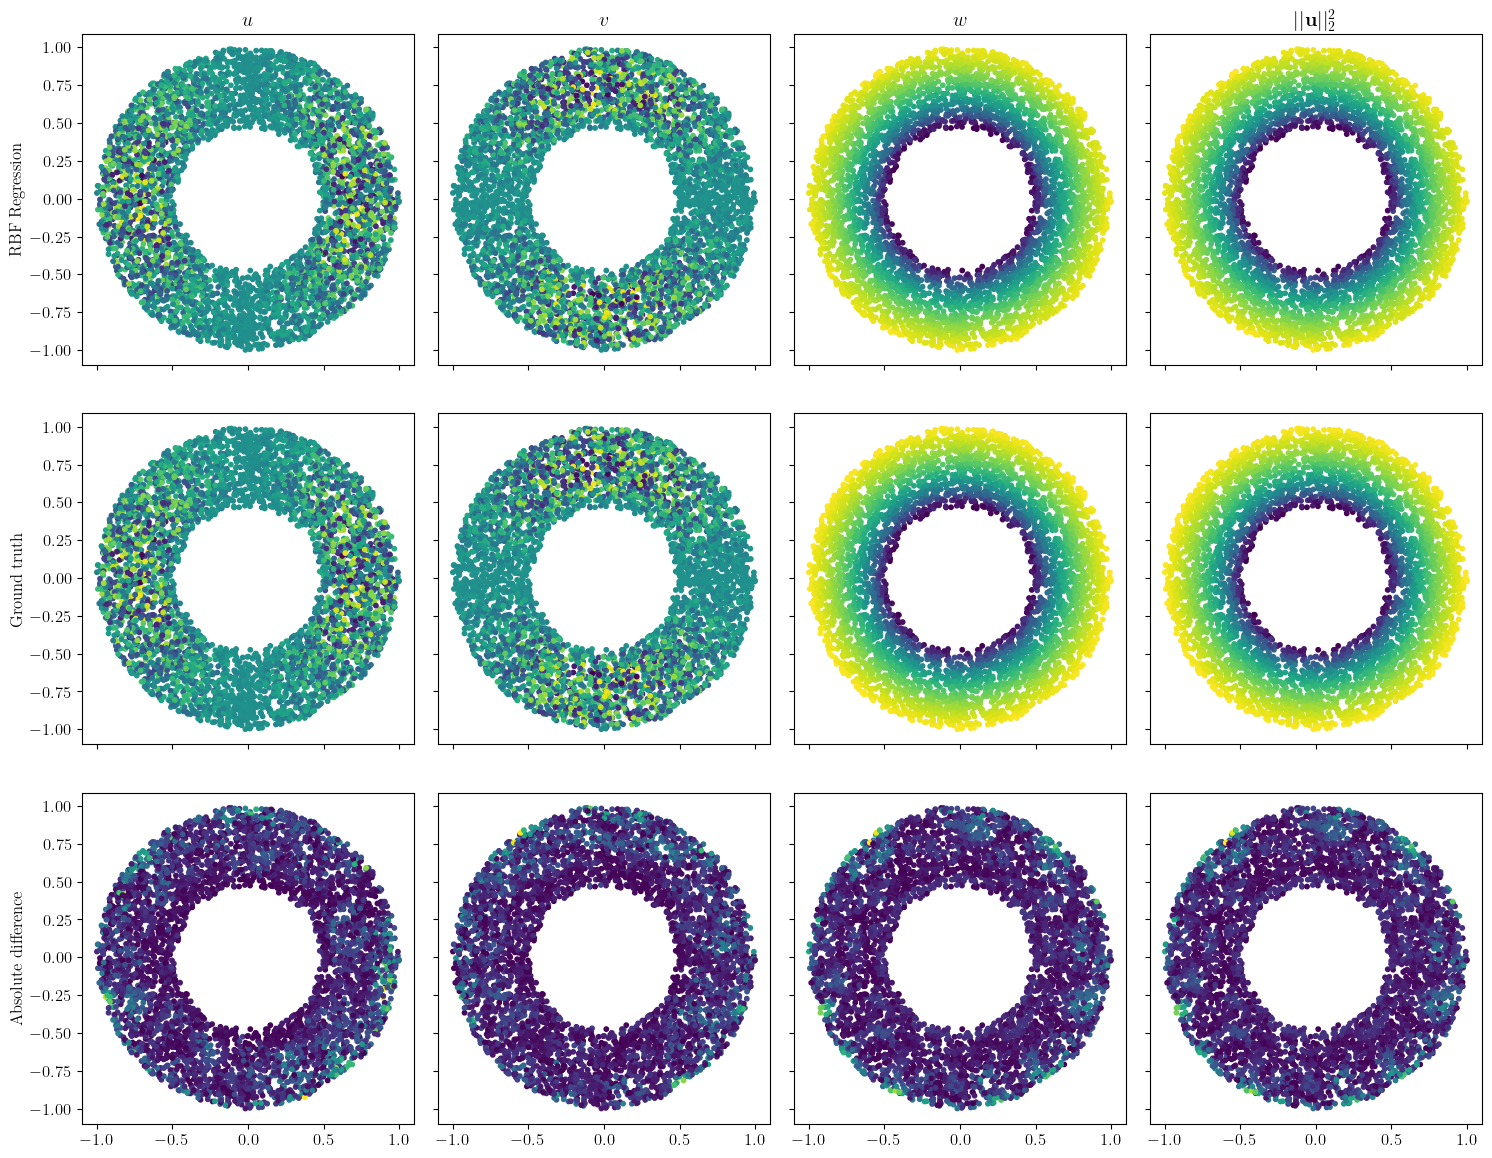

In [8]:
central_slice = np.logical_and(Z < 0.2, Z > -0.2)
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(15,12), dpi=100, sharex=True, sharey=True)
axes[0,0].scatter(X[central_slice], Y[central_slice], c=U_calc[central_slice], s=10)
axes[1,0].scatter(X[central_slice], Y[central_slice], c=U[central_slice], s=10)
axes[2,0].scatter(X[central_slice], Y[central_slice], c=np.abs(U_calc[central_slice]-U[central_slice]), s=10) 

axes[0,1].scatter(X[central_slice], Y[central_slice], c=V_calc[central_slice], s=10)
axes[1,1].scatter(X[central_slice], Y[central_slice], c=V[central_slice], s=10)
axes[2,1].scatter(X[central_slice], Y[central_slice], c=np.abs(V_calc[central_slice]-V[central_slice]), s=10)  

axes[0,2].scatter(X[central_slice], Y[central_slice], c=W_calc[central_slice], s=10)
axes[1,2].scatter(X[central_slice], Y[central_slice], c=W[central_slice], s=10)
axes[2,2].scatter(X[central_slice], Y[central_slice], c=np.abs(W_calc[central_slice]-W[central_slice]), s=10) 

axes[0,3].scatter(X[central_slice], Y[central_slice], c=U_magn_calc[central_slice], s=10)
axes[1,3].scatter(X[central_slice], Y[central_slice], c=U_magn[central_slice], s=10)
axes[2,3].scatter(X[central_slice], Y[central_slice], c=np.abs(U_magn_calc[central_slice]-U_magn[central_slice]), s=10) 


axes[0,0].set_ylabel('RBF Regression') 
axes[1,0].set_ylabel('Ground truth')  
axes[2,0].set_ylabel('Absolute difference')  

axes[0,0].set_title('$u$') 
axes[0,1].set_title('$v$')  
axes[0,2].set_title('$w$')  
axes[0,3].set_title('$||\mathbf{u}||_2^2$')      
for ax in axes.flatten():
    ax.set_aspect(1)      
fig.tight_layout()      

### Step 4: Pressure computation

For the pressure computation, we follow similar steps as in the cylinder tutorial. These are: 

1. On all boundaries, we introduce Neumann conditions (these will be computed directly from the velocity field). To impose these we will need to prepare the vector of normals over each of them. These conditions do not require extra measurements. For simplicity, we take these points to be the same as for the velocity regression.

2. On the surface of the sphere, we position 6 Dirichlet conditions, simulating pressure taps during experiments. These points come from the analytical solution and again help to give a more robust pressure integration.

In [9]:
################################# Define the Location for the Neumann conditions ##################################
# Assemble the the entire array of Neumann points
X_Pres_N = np.concatenate((X_Outer, X_Inner))
Y_Pres_N = np.concatenate((Y_Outer, Y_Inner))
Z_Pres_N = np.concatenate((Z_Outer, Z_Inner))

############################### Compute the normal vectors for all patches requireing N conditions #################
# Inner sphere
n_x_1 = np.cos(phi_sphere_outer)*np.sin(theta_sphere_outer)
n_y_1 = np.sin(phi_sphere_outer)*np.sin(theta_sphere_outer)
n_z_1 = np.cos(theta_sphere_outer)
# Outer sphere
n_x_2 = np.cos(phi_sphere_inner)*np.sin(theta_sphere_inner)
n_y_2 = np.sin(phi_sphere_inner)*np.sin(theta_sphere_inner)
n_z_2 = np.cos(theta_sphere_inner)
# Assemble to obtain the entire array of Neumann normals
n_x = np.concatenate((n_x_1, n_x_2))
n_y = np.concatenate((n_y_1, n_y_2))  
n_z = np.concatenate((n_z_1, n_z_2))

# Remove the duplicates for the normals
_, valid_idcs = np.unique(np.column_stack((X_Pres_N, Y_Pres_N, Z_Pres_N)), return_index = True, axis = 0)
X_Pres_N = X_Pres_N[valid_idcs]
Y_Pres_N = Y_Pres_N[valid_idcs]
Z_Pres_N = Z_Pres_N[valid_idcs]
n_x = n_x[valid_idcs]
n_y = n_y[valid_idcs]
n_z = n_z[valid_idcs]

############# Define location (and value) for the Dirichlet (D) condition on the surface of the inner sphere ##############
# Simulated pressure taps on the sphere
X_taps = np.array([X_center_sphere,X_center_sphere,X_center_sphere,X_center_sphere,X_center_sphere+D/2,X_center_sphere-D/2])
Y_taps = np.array([Y_center_sphere,Y_center_sphere,Y_center_sphere+D/2,Y_center_sphere-D/2,Y_center_sphere,Y_center_sphere])
Z_taps = np.array([Z_center_sphere+D/2,Z_center_sphere-D/2,Z_center_sphere,Z_center_sphere,Z_center_sphere,Z_center_sphere])

# For the Dirichlet boundary conditions
# Get the pressure taps
X_Pres_D = X_taps
Y_Pres_D = Y_taps
Z_Pres_D = Z_taps
# And compute the pressure from the analytical solution
phi_Pres_D = np.arctan2(Y_Pres_D-Y_center_sphere, X_Pres_D-X_center_sphere)
theta_Pres_D = np.arctan2(np.sqrt((X_Pres_D-X_center_sphere)**2 + (Y_Pres_D-Y_center_sphere)**2), (Z_Pres_D-Z_center_sphere))
r_Pres_D = np.sqrt((X_Pres_D-X_center_sphere)**2 + (Y_Pres_D-Y_center_sphere)**2 + (Z_Pres_D-Z_center_sphere)**2)
P_Pres_D = -1.5*((mu*U_0*R/r_Pres_D**2))*np.cos(theta_Pres_D)

We now assembly the Poisson problem. First compute the source term from the velocity field and the N conditions.

In [ ]:
# First we compute the required quantities from the velocity field 
# (neither of the following 2 steps runs if SP_Vel has not been solved)
# 1. Evaluate the source term on the RHS of the Poisson equation
source_term = SP_vel.Evaluate_Source_Term(grid=[X,Y,Z], rho=rho)
# 2. Evaluate the c_N for the N conditions (see Presentation 1)
P_Neu = SP_vel.Get_Pressure_Neumann(grid = [X_Pres_N, Y_Pres_N, Z_Pres_N], 
                                    normals = [n_x, n_y, n_z],
                                    rho = rho, mu = mu)
# We can now proceed with (1) spicy initialization (2) clustering (3) constraint assingment, (4) System Assembly:
NEU_P = [X_Pres_N, Y_Pres_N, Z_Pres_N, n_x, n_y, n_z, P_Neu]
DIR_P = [X_Pres_D, Y_Pres_D, Z_Pres_D, P_Pres_D]
                                    
SP_pres = spicy([source_term], [X,Y,Z], basis='gauss')
SP_pres.clustering([6,60,1200], Areas=[[], [], []], r_mM=[0.1, 0.65], eps_l=0.78)

# And, we set them
SP_pres.scalar_constraints(DIR=DIR_P, NEU=NEU_P, extra_RBF=True)
# Plot the clustering a level 
SP_pres.plot_RBFs(l=0) 
 # Assembly the system
SP_pres.Assembly_Poisson()

Clustering level 0 completed
Clustering level 1 completed
Clustering level 2 completed
3402 RBFs placed through clustering
6 Dirichlet conditions assigned
6980 Neumann conditions assigned


In [ ]:
# Solve the system
SP_pres.Solve(K_cond=1e12)
# Compute the pressure
P_calc = SP_pres.Get_Sol(grid=[X,Y,Z])

# print the pressure error
error_p = np.linalg.norm(P - P_calc)/np.linalg.norm(P)
print('Total pressure error: {0:.3f}%'.format(error_p*100))

We close by comparing the calculated and ground truth pressure field.

In [ ]:
central_slice = np.logical_and(Z < 0.2, Z > -0.2)
fig, axes = plt.subplots(figsize=(15,5), dpi=100, ncols=3, sharey=True)
axes[0].scatter(X[central_slice], Y[central_slice], c=P_calc[central_slice], s=10)
axes[0].set_title('Computed pressure field')
axes[1].scatter(X[central_slice], Y[central_slice], c=P[central_slice], s=10)
axes[1].set_title('Analytical pressure field')
axes[2].scatter(X[central_slice], Y[central_slice], c=np.abs(P_calc[central_slice]-P[central_slice]), s=10)
axes[2].set_title('Absolute difference')           
for ax in axes.flatten():
    ax.set_aspect(1)
fig.tight_layout()

The error of the pressure computation is one order of magnitude higher compared to the velocity regression. Larger differences are located near the outer shell. This is linked to the boundary conditions: The Dirichlet conditions on the surface of the inner sphere greatly stabilize the pressure computation, if they are removed, then larger errors are also present in this region. This highlights the need for pressure taps on surfaces. If enough taps are present, the pressure field is accurate which can be used to compute the aerodynamic load and drag of objects!